# Predicting Prime Numbers Using Machine Learning

This notebook explores whether machine learning models can learn patterns that distinguish prime numbers from composite ones.  
The workflow includes:

1. **Data Generation** – Creating a dataset of integers and labeling them as prime or non-prime.  
2. **Feature Engineering** – Extracting modular and pattern-based numerical features (e.g., residues mod 2, 3, 5, 6, 30).  
3. **Modeling** – Training and evaluating classification models, including Random Forest, KNN, and XGBoost.  
4. **Evaluation** – Using metrics beyond accuracy, such as precision, recall, F1-score, and confusion matrices.  
5. **Hyperparameter Tuning** – Optimizing model parameters with cross-validation to improve performance.  
6. **Feature Importance Analysis** – Understanding which numerical patterns contribute most to predicting primality.

The goal is to test whether statistical learning can approximate prime identification patterns.


## Imports and Dependencies

We start by importing the necessary libraries for data handling, mathematical operations, and machine learning.

- **NumPy** and **Pandas** handle numerical computations and data manipulation.  
- **Sympy** provides the `isprime` function for labeling integers as prime or non-prime.  
- **scikit-learn** modules support model building, cross-validation, hyperparameter tuning, and evaluation metrics.  
- **RandomForestClassifier** and **KNeighborsClassifier** serve as ensemble and distance-based baseline models.  
- **XGBClassifier** (from XGBoost) provides a GPU-accelerated gradient boosting model for comparison.


In [1]:
import numpy as np
import pandas as pd
from sympy import isprime
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns


## Data Generation

We begin by creating a simple range of integers from 2 to 9,999.  
This sequence will form the foundation of our dataset, where each number will later be labeled as **prime** or **non-prime**.

In [2]:
# We're creating a range of integers
numbers = np.arange(2, 10000)

## Labeling Prime Numbers

Each integer in the range is labeled using Sympy’s `isprime()` function.  
If a number is prime, it receives a label of **1**; otherwise, it receives a label of **0**.  
This creates the target variable for our classification task.

In [3]:
# Label prime numbers
labels = np.array([1 if isprime(n) else 0 for n in numbers])

## Creating the Dataset

We combine the numbers and their corresponding prime labels into a Pandas DataFrame.  
The resulting dataset has two columns:

- `number` – the integer itself  
- `is_prime` – the target label indicating whether the number is prime (1) or not (0)

In [4]:
# Make it a dataset
data = pd.DataFrame({
    'number' : numbers,
    'is_prime' : labels
})

## Checking Class Balance

Before modeling, we inspect the distribution of prime and non-prime numbers.  
This helps identify any class imbalance that could affect model performance and informs whether we need to apply techniques like `class_weight` or resampling.

In [5]:
# Check class balance
print(data['is_prime'].value_counts())

is_prime
0    8769
1    1229
Name: count, dtype: int64


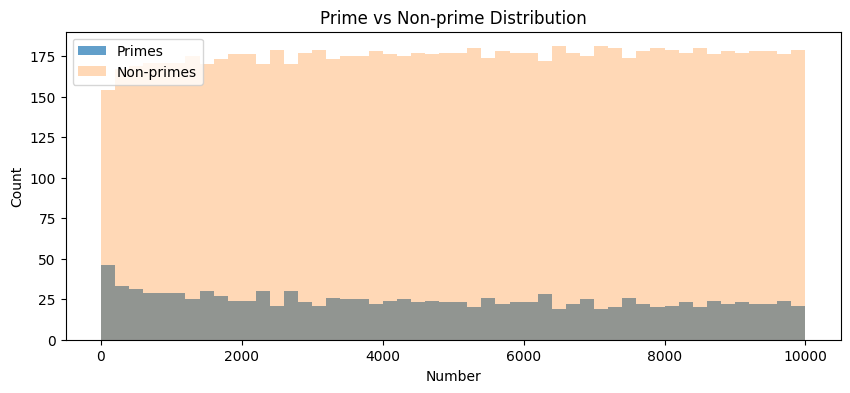

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.hist(data['number'], bins=50, weights=data['is_prime'], alpha=0.7, label='Primes')
plt.hist(data['number'], bins=50, weights=1-data['is_prime'], alpha=0.3, label='Non-primes')
plt.xlabel('Number')
plt.ylabel('Count')
plt.title('Prime vs Non-prime Distribution')
plt.legend()
plt.show()

The classes are clearly imbalanced.

## Feature Engineering: Basic Numerical Features

We define a function to extract modular and pattern-based features from each number:

1. **mod_2** – whether the number is even or odd.  
2. **mod_3** – remainder when divided by 3, highlighting multiples of 3.  
3. **mod_5** – remainder when divided by 5, capturing numbers ending in 0 or 5.  
4. **mod_6** – remainder when divided by 6, related to the 6k ± 1 pattern for primes greater than 3.  
5. **mod_30** – remainder when divided by 30, representing the 30k ± {1,7,11,13,17,19,23,29} pattern for primes greater than 5.

These features provide numerical cues for the machine learning models to distinguish prime from non-prime numbers.


In [7]:
# Make function to engineer all our features
def basic_features(df):
    df = df.copy()
    n = df['number']

    # Feature 1 : Tell us if number even or odd
    df['mod_2'] = n % 2

    # Feature 2 : Find multiples of 3
    df['mod_3'] = n % 3

    # Feature 3 : Find numbers ending in 0 or 5
    df['mod_5'] = n % 5

    # Feature 4 : capture 6k +- 1 pattern for primes > 3
    df['mod_6'] = n % 6

    # Feature 5 : capture the 30k pattern for primality
    df["mod_30"] = n % 30

    return df

In [8]:
# Apply function to existing data
data_features = basic_features(data)

# And check first few rows
data_features.head()

,number,is_prime,mod_2,mod_3,mod_5,mod_6,mod_30
0,2,1,0,2,2,2,2
1,3,1,1,0,3,3,3
2,4,0,0,1,4,4,4
3,5,1,1,2,0,5,5
4,6,0,0,0,1,0,6


## Experimental Features: Probable Prime Patterns

We create additional features to explicitly capture known prime patterns:

1. **probably_prime_6k** – Flags numbers greater than 3 that follow the 6k ± 1 pattern.  
2. **probably_prime_30k** – Flags numbers greater than 5 whose remainder modulo 30 is one of {1, 7, 11, 13, 17, 19, 23, 29}.

These “probable prime” features encode mathematical insights directly, allowing us to test whether the model benefits from these explicit rules in addition to the basic modular features.


In [9]:
# Make copy of clean feature dataframe
data_features_exp = data_features.copy()

# 6k ± 1 pattern
# Primes greater than 3 are of the form 6k ± 1, meaning n % 6 == 1 or 5
data_features_exp['probably_prime_6k'] = data_features_exp['number'].apply(
    lambda n: 1 if n % 6 in (1, 5) else 0
)

# 30k ± {1, 7, 11, 13, 17, 19, 23, 29} pattern
# Primes greater than 5 fall into these remainders mod 30
prime_residues_30 = [1, 7, 11, 13, 17, 19, 23, 29]
data_features_exp['probably_prime_30k'] = data_features_exp['number'].apply(
    lambda n: 1 if n % 30 in prime_residues_30 else 0
)

# Look at the first few rows
data_features_exp.head()


,number,is_prime,mod_2,mod_3,mod_5,mod_6,mod_30,probably_prime_6k,probably_prime_30k
0,2,1,0,2,2,2,2,0,0
1,3,1,1,0,3,3,3,0,0
2,4,0,0,1,4,4,4,0,0
3,5,1,1,2,0,5,5,1,0
4,6,0,0,0,1,0,6,0,0


## Cross-Validation Setup

We create a **stratified 10-fold cross-validation** object to evaluate our models.  

- **StratifiedKFold** ensures that each fold preserves the proportion of prime and non-prime numbers.  
- **n_splits=10** divides the data into 10 folds.  
- **shuffle=True** randomizes the data before splitting.  
- **random_state=42** ensures reproducibility of the splits.

In [10]:
# Create stratified cross-validation object
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

## Separating Features and Target

We split the dataset into:

- **X** – the input features used by the model (`mod_2`, `mod_3`, `mod_5`, `mod_6`, `mod_30`).  
- **y** – the target variable (`is_prime`), indicating whether a number is prime (1) or not (0).

This separation is required for model training and evaluation.


In [11]:
#separate input (x) and y (target)
X = data_features.drop(columns=['is_prime'])
y = data_features['is_prime']

## Random Forest Model Initialization

We create a Random Forest classifier with the following settings:

- **n_estimators=200** – number of trees in the forest.  
- **max_depth=None** – trees expand until all leaves are pure or contain less than `min_samples_split`.  
- **class_weight='balanced'** – accounts for class imbalance by weighting prime numbers higher.  
- **random_state=42** – ensures reproducibility of results.  
- **n_jobs=-1** – uses all available CPU cores for parallel computation.

In [12]:
# random forest object
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

## Baseline Model Evaluation with Cross-Validation

We evaluate the Random Forest model using 10-fold stratified cross-validation with multiple metrics:

- **precision** – proportion of predicted primes that are actually prime.  
- **recall** – proportion of actual primes correctly identified.  
- **F1-score** – harmonic mean of precision and recall, useful for imbalanced classes.  
- **accuracy** – proportion of all correct predictions.

`cross_validate` runs the model across all folds and returns the mean score for each metric, giving a baseline performance before hyperparameter tuning.

In [13]:
scoring = ['precision', 'recall', 'f1', 'accuracy']

scores = cross_validate(rf, X, y, cv=cv, scoring=scoring, n_jobs=-1)

for metric in scoring:
    print(f"{metric}: {scores['test_' + metric].mean():.4f}")

precision: 0.4393
recall: 0.4426
f1: 0.4402
accuracy: 0.8619


Observations:

- Accuracy is high due to the large number of non-prime numbers, but the F1-score indicates moderate performance in detecting primes.  
- Precision and recall are roughly equal, suggesting the model treats false positives and false negatives similarly.  
- This baseline establishes a reference point for improvements through hyperparameter tuning and experimental features.

## Confusion Matrix and Detailed Classification Report

To better understand model performance beyond averaged metrics, we:

1. Use `cross_val_predict` to get predictions for each sample across all folds.  
2. Compute a **confusion matrix** to visualize true positives, true negatives, false positives, and false negatives.  
3. Plot the matrix using a heatmap for clarity.  
4. Print a **classification report** showing precision, recall, F1-score, and support for each class.

This step allows us to inspect where the model succeeds and fails in predicting prime and non-prime numbers.


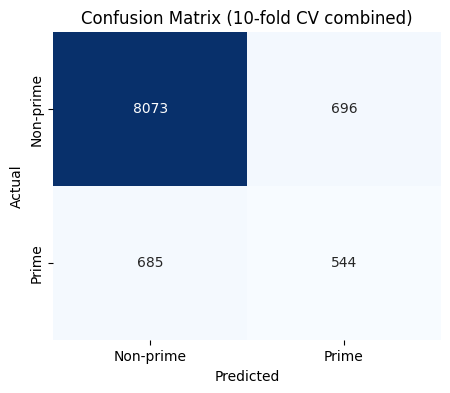


Classification Report:

              precision    recall  f1-score   support

   Non-prime       0.92      0.92      0.92      8769
       Prime       0.44      0.44      0.44      1229

    accuracy                           0.86      9998
   macro avg       0.68      0.68      0.68      9998
weighted avg       0.86      0.86      0.86      9998



In [14]:
# Get predictions for each sample using 10-fold cross-validation
y_pred_all = cross_val_predict(rf, X, y, cv=cv, n_jobs=-1)

# Compute confusion matrix
cm = confusion_matrix(y, y_pred_all)

# Visualize it
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-prime', 'Prime'],
            yticklabels=['Non-prime', 'Prime'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (10-fold CV combined)')
plt.show()

# Detailed report
print("\nClassification Report:\n")
print(classification_report(y, y_pred_all, target_names=['Non-prime', 'Prime']))


The model’s performance breakdown:

- **Non-prime class:** High precision and recall (0.92), showing the model accurately identifies most non-prime numbers.  
- **Prime class:** Moderate precision and recall (0.44), indicating the model struggles more with correctly identifying primes.  
- **Accuracy:** 0.86, inflated by the large number of non-primes.  
- **Macro average F1-score:** 0.68, reflecting balanced consideration of both classes.  
- **Weighted average F1-score:** 0.86, influenced by the dominant non-prime class.

Observation: The model is biased toward the majority class (non-prime), highlighting the need for techniques like class weighting or feature engineering to improve prime detection.

## Experimental Feature Set: Separating Inputs and Target

For the dataset with experimental “probably prime” features, we separate:

- **X_exp** – input features including basic modular features and the new probable prime indicators (`probably_prime_6k`, `probably_prime_30k`).  
- **y_exp** – the target variable (`is_prime`) indicating whether a number is prime (1) or not (0).

This prepares the experimental feature set for model training and evaluation.

In [15]:
X_exp = data_features_exp.drop(columns=["is_prime"])
y_exp = data_features_exp["is_prime"]

## Evaluating Random Forest with Experimental Features

We perform 10-fold stratified cross-validation on the dataset including the probable prime features.  

- Metrics calculated: **precision**, **recall**, **F1-score**, and **accuracy**.  
- `cross_validate` returns scores for each fold, and we report the **mean** across all folds.  

This allows us to compare whether adding the “probably prime” features improves model performance over the baseline.

In [16]:
scoring = ['precision', 'recall', 'f1', 'accuracy']

scores = cross_validate(rf, X_exp, y_exp, cv=cv, scoring=scoring, n_jobs=-1)

for metric in scoring:
    print(f"{metric}: {scores['test_' + metric].mean():.4f}")

precision: 0.4393
recall: 0.4426
f1: 0.4402
accuracy: 0.8619


Observation:

- The additional “probably prime” features did not change model performance compared to the baseline.  

## Confusion Matrix and Classification Report for Experimental Features

We use `cross_val_predict` to obtain predictions across all folds for the dataset with experimental features.  

- Compute and visualize the **confusion matrix** to see true positives, true negatives, false positives, and false negatives.  
- Print a **classification report** showing precision, recall, F1-score, and support for each class.

This allows direct comparison of how the experimental features affect model performance versus the baseline.

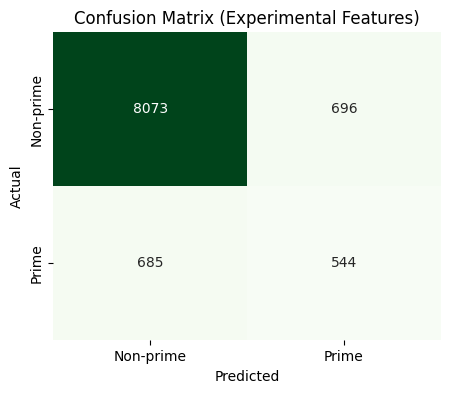


Classification Report:

              precision    recall  f1-score   support

   Non-prime       0.92      0.92      0.92      8769
       Prime       0.44      0.44      0.44      1229

    accuracy                           0.86      9998
   macro avg       0.68      0.68      0.68      9998
weighted avg       0.86      0.86      0.86      9998



In [17]:
# Get predictions across all folds
y_pred_exp = cross_val_predict(rf, X_exp, y_exp, cv=cv, n_jobs=-1)

# Compute confusion matrix
cm_exp = confusion_matrix(y_exp, y_pred_exp)

# Visualize it
plt.figure(figsize=(5, 4))
sns.heatmap(cm_exp, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Non-prime', 'Prime'],
            yticklabels=['Non-prime', 'Prime'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Experimental Features)')
plt.show()

# Print classification report
print("\nClassification Report:\n")
print(classification_report(y_exp, y_pred_exp, target_names=['Non-prime', 'Prime']))

- Random Forest already captured the patterns represented by these features, making them redundant.

## Hyperparameter Tuning with Grid Search

We perform a grid search to optimize the Random Forest parameters using 10-fold stratified cross-validation:

- **Parameter grid (`param_grid`)** includes:
  - `n_estimators`: number of trees in the forest.  
  - `max_depth`: maximum depth of each tree.  
  - `min_samples_split`: minimum samples required to split a node.  
  - `min_samples_leaf`: minimum samples required at a leaf node.  
  - `max_features`: number of features considered at each split.  
  - `class_weight`: handle class imbalance by weighting pr_

In [18]:
# define grid parameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}

# set up actual grid search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# then actually fit it
grid_search.fit(X, y)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_estimators=200, n_jobs=-1,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='f1', verbose=1)

In [19]:
print("Best parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

Best parameters: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 score: 0.6302464887059986


The corresponding cross-validated **F1-score** is approximately **0.630**, indicating an improvement over the baseline model.  

These parameters balance tree complexity, class imbalance, and feature sampling to maximize prime detection.

## Final Tuned Random Forest Model

We extract the best estimator from the grid search and assign it to `rf_best`.  

This model incorporates the optimal hyperparameters identified and can now be used for cross-validated evaluation, predictions, and feature importance analysis.

In [20]:
rf_best = grid_search.best_estimator_

## Evaluating the Tuned Random Forest

We perform 10-fold stratified cross-validation on the tuned Random Forest (`rf_best`) to measure performance:

- Metrics calculated: **precision**, **recall**, **F1-score**, and **accuracy**.  
- Both the **mean** and **standard deviation** across folds are reported to show average performance and variability.  

This provides a more reliable assessment of how the optimized model generalizes to unseen data.

In [21]:
# Evaluate the tuned model (mean + std for metrics)
rf_best = grid_search.best_estimator_

scoring = ['precision', 'recall', 'f1', 'accuracy']
scores_best = cross_validate(rf_best, X, y, cv=cv, scoring=scoring, n_jobs=-1)

for metric in scoring:
    print(f"{metric}: {scores_best['test_' + metric].mean():.4f}  ± {scores_best['test_' + metric].std():.4f}")

precision: 0.4609  ± 0.0212
recall: 0.9976  ± 0.0037
f1: 0.6302  ± 0.0199
accuracy: 0.8558  ± 0.0115


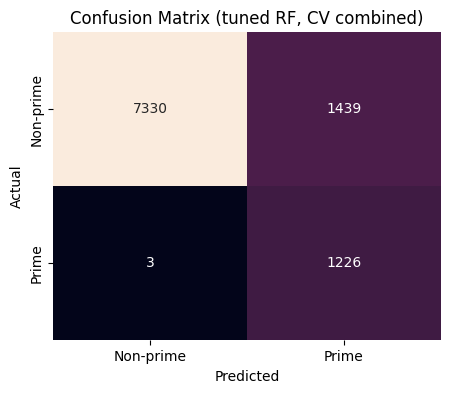

              precision    recall  f1-score   support

   Non-prime       1.00      0.84      0.91      8769
       Prime       0.46      1.00      0.63      1229

    accuracy                           0.86      9998
   macro avg       0.73      0.92      0.77      9998
weighted avg       0.93      0.86      0.88      9998



In [22]:
# Get predicted labels across folds and show a visual confusion matrix + classification report
y_pred_best = cross_val_predict(rf_best, X, y, cv=cv, n_jobs=-1)

cm = confusion_matrix(y, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cbar=False,
            xticklabels=['Non-prime','Prime'],
            yticklabels=['Non-prime','Prime'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (tuned RF, CV combined)')
plt.show()

print(classification_report(y, y_pred_best, target_names=['Non-prime','Prime']))

## Feature Importance Analysis

We examine which features contribute most to the tuned Random Forest’s predictions:

- `feature_importances_` provides the relative importance of each input feature.  
- Sorting and visualizing the top 20 features allows us to identify which numerical patterns (modular features or probable prime indicators) the model relies on most.  
- The horizontal bar plot shows the magnitude of each feature’s impact, helping interpret the model’s decision process.

mod_2     0.393823
mod_3     0.219034
mod_6     0.176975
mod_5     0.109906
mod_30    0.059121
number    0.041141
dtype: float64


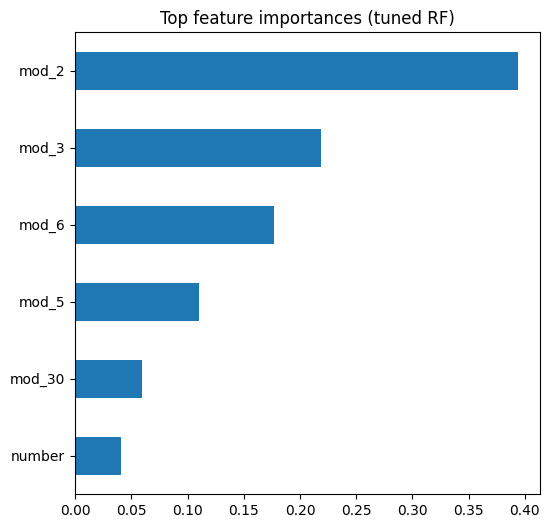

In [23]:
# Check feature importance to learn what the model uses
fi = pd.Series(rf_best.feature_importances_, index=X.columns).sort_values(ascending=False)
print(fi.head(20))
# simple bar plot
fi.head(20).plot.barh(figsize=(6,6))
plt.gca().invert_yaxis()
plt.title('Top feature importances (tuned RF)')
plt.show()

## XGBoost Model

We now train an **XGBoost classifier** to predict prime numbers.  

- XGBoost is a gradient boosting ensemble method that often outperforms Random Forest on structured data.  
- We enable **GPU acceleration** with `tree_method='gpu_hist'` to speed up training.  
- Cross-validation and hyperparameter tuning will follow the same approach as with the Random Forest model, allowing direct comparison.


In [24]:
from xgboost import XGBClassifier
# Initialize GPU-enabled XGBoost model
xgb_model = XGBClassifier(
    tree_method='gpu_hist',      # enables GPU acceleration
    predictor='gpu_predictor',   # ensures predictions use GPU
    use_label_encoder=False,     # suppresses label encoding warning
    eval_metric='logloss',       # evaluation metric
    random_state=42
)

In [25]:
# Define scoring metrics
scoring = ['precision', 'recall', 'f1', 'accuracy']

# Perform 10-fold stratified cross-validation
scores_xgb = cross_validate(xgb_model, X, y, cv=cv, scoring=scoring, n_jobs=-1)

# Print mean ± std for each metric
for metric in scoring:
    mean = scores_xgb['test_' + metric].mean()
    std = scores_xgb['test_' + metric].std()
    print(f"{metric}: {mean:.4f} ± {std:.4f}")

precision: 0.3771 ± 0.0390
recall: 0.2986 ± 0.0195
f1: 0.3327 ± 0.0249
accuracy: 0.8525 ± 0.0095


Observations:

- Compared to the Random Forest baseline, XGBoost has lower precision and recall for prime numbers.  
- Accuracy is high due to the majority non-prime class, but the low F1-score indicates difficulty identifying primes.  
- This establishes a baseline for XGBoost before hyperparameter tuning.

## Confusion Matrix and Classification Report for XGBoost

We evaluate the XGBoost baseline model using predictions obtained from 10-fold cross-validation:

1. **cross_val_predict** generates predictions for every sample across all folds.  
2. **Confusion matrix** shows counts of true positives, true negatives, false positives, and false negatives.  
3. A **heatmap** visualizes the confusion matrix for clarity.  
4. **Classification report** displays precision, recall, F1-score, and support for each class.  

This analysis highlights how well XGBoost distinguishes prime and non-prime numbers before any hyperparameter tuning.

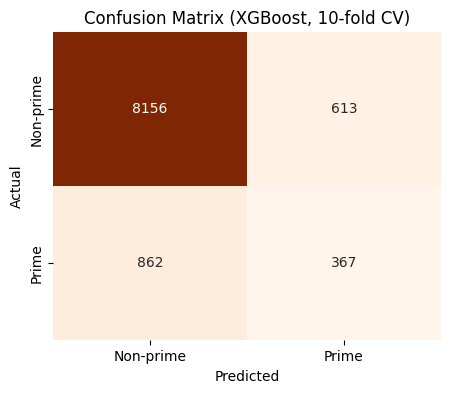


Classification Report:

              precision    recall  f1-score   support

   Non-prime       0.90      0.93      0.92      8769
       Prime       0.37      0.30      0.33      1229

    accuracy                           0.85      9998
   macro avg       0.64      0.61      0.62      9998
weighted avg       0.84      0.85      0.85      9998



In [26]:
# Get predictions for all samples using cross-validation
y_pred_xgb = cross_val_predict(xgb_model, X, y, cv=cv, n_jobs=-1)

# Compute confusion matrix
cm_xgb = confusion_matrix(y, y_pred_xgb)

# Visualize confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['Non-prime', 'Prime'],
            yticklabels=['Non-prime', 'Prime'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (XGBoost, 10-fold CV)')
plt.show()


# Detailed classification report
print("\nClassification Report:\n")
print(classification_report(y, y_pred_xgb, target_names=['Non-prime', 'Prime']))

- **Non-prime class:** High precision and recall (0.90–0.93), meaning most non-prime numbers are correctly identified.  
- **Prime class:** Lower precision and recall (0.37 and 0.30), showing the model struggles to correctly detect primes.  
- **Accuracy:** 0.85, inflated by the large number of non-primes.  
- **Macro F1-score:** 0.62, reflecting average performance across both classes.  
- **Weighted F1-score:** 0.85, influenced by the majority non-prime class.

Observation: XGBoost baseline performs worse than Random Forest in detecting primes, reinforcing the need for hyperparameter tuning.

## Hyperparameter Tuning for XGBoost

We will optimize the XGBoost classifier using **GridSearchCV** with 10-fold stratified cross-validation:

- Tune parameters like:
  - `n_estimators` – number of boosting rounds  
  - `max_depth` – maximum tree depth  
  - `learning_rate` – step size shrinkage  
  - `subsample` – fraction of samples per tree  
  - `colsample_bytree` – fraction of features per tree  

- Use **F1-score** as the evaluation metric to balance precision and recall for the minority prime class.  
- GPU acceleration (`tree_method='gpu_hist'`) ensures faster training during grid search.

In [27]:
# Define hyperparameter grid
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize XGBoost model
xgb_model = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Set up GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit grid search
grid_search_xgb.fit(X, y)

# Best parameters and F1-score
print("Best parameters:", grid_search_xgb.best_params_)
print("Best F1 score:", grid_search_xgb.best_score_)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


c:\Users\HP\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:21:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\HP\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:21:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 300, 'subsample': 0.8}
Best F1 score: 0.41257723779717564


In [28]:
# Assuming your GridSearchCV object is called grid_search_xgb
xgb_best = grid_search_xgb.best_estimator_

The grid search picked the maximum `n_estimators` and `max_depth`, highest `learning_rate`, and lowest `subsample`/`colsample_bytree`.  

This suggests:

- The **true optimal parameters may lie outside the current grid**.  
- The model prefers aggressive learning with fewer samples/features per tree.  
- There is a **risk of overfitting**, but cross-validation mitigates some of it.

Next steps:

- Expand the parameter ranges for `n_estimators`, `max_depth`, and try smaller `learning_rate`.  
- Include finer granularity for `subsample` and `colsample_bytree` to find the sweet spot.

Regardless, a substantial improvement is very unlikely to be noted because this is a rule-based problem, which XGBoost does not handle well.

In [29]:
# Generate large, random test numbers
test_numbers = [
    1000003, 1000033, 1000037, 1000039, 1000081, 1000099,   # primes
    1000000, 1000010, 1000020, 1000040, 1000050, 1000060    # composites
]

def predict_prime(model, numbers):
    """
    Predict primality for a number or list of numbers using a trained Random Forest model.
    Returns numpy array of predictions (0 = non-prime, 1 = prime).
    """
    if isinstance(numbers, int):
        numbers = [numbers]
    
    df = pd.DataFrame({'number': numbers})
    df_features = basic_features(df)
    
    if 'is_prime' in df_features.columns:
        df_features = df_features.drop(columns=['is_prime'])
    
    preds = model.predict(df_features)
    return preds

# Model predictions
model_preds = predict_prime(rf_best, test_numbers)

# True labels using sympy
true_labels = [int(isprime(n)) for n in test_numbers]

# Optional: print first few predictions
for n, pred, true in zip(test_numbers[:10], model_preds[:10], true_labels[:10]):
    print(f"Number: {n} | Model prediction: {pred} | True: {true} | Correct: {pred == true}")

# Full classification report
print("\nClassification report for large random test set:")
print(classification_report(true_labels, model_preds, target_names=['Non-prime', 'Prime']))


Number: 1000003 | Model prediction: 1 | True: 1 | Correct: True
Number: 1000033 | Model prediction: 1 | True: 1 | Correct: True
Number: 1000037 | Model prediction: 0 | True: 1 | Correct: False
Number: 1000039 | Model prediction: 1 | True: 1 | Correct: True
Number: 1000081 | Model prediction: 1 | True: 1 | Correct: True
Number: 1000099 | Model prediction: 1 | True: 1 | Correct: True
Number: 1000000 | Model prediction: 0 | True: 0 | Correct: True
Number: 1000010 | Model prediction: 0 | True: 0 | Correct: True
Number: 1000020 | Model prediction: 0 | True: 0 | Correct: True
Number: 1000040 | Model prediction: 0 | True: 0 | Correct: True

Classification report for large random test set:
              precision    recall  f1-score   support

   Non-prime       0.86      1.00      0.92         6
       Prime       1.00      0.83      0.91         6

    accuracy                           0.92        12
   macro avg       0.93      0.92      0.92        12
weighted avg       0.93      0.92    

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select features
X_cluster = data_features[['mod_2','mod_3','mod_5','mod_6','mod_30']]

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# K-means
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_scaled)

# Cluster labels
data_features['cluster'] = kmeans.labels_

In [31]:
data_features.groupby('cluster')['is_prime'].value_counts()

cluster  is_prime
0        0           4384
         1            611
1        0           4385
         1            618
Name: count, dtype: int64

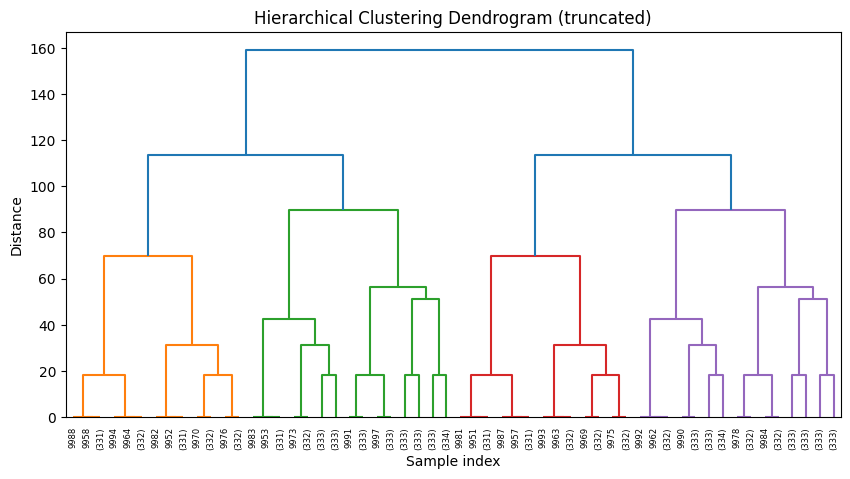

In [ ]:
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select features
X_hier = data_features[['mod_2','mod_3','mod_5','mod_6','mod_30']]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_hier)

# Compute linkage matrix
linkage_matrix = sch.linkage(X_scaled, method='ward')  # 'ward' minimizes variance within clusters

# Plot dendrogram (you can cut it at some distance to form clusters)
plt.figure(figsize=(10, 5))
dendrogram = sch.dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [34]:
from scipy.cluster.hierarchy import fcluster

# Form clusters, e.g., 2 clusters
clusters = fcluster(linkage_matrix, t=2, criterion='maxclust')
data_features['hier_cluster'] = clusters

# Check how many primes are in each cluster
print(data_features.groupby('hier_cluster')['is_prime'].value_counts())


hier_cluster  is_prime
1             0           4387
              1            612
2             0           4382
              1            617
Name: count, dtype: int64
